<a href="https://colab.research.google.com/github/Seungwoo-Hong-data/deep-class/blob/main/deep_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration: 1	Value difference: 1.0
Iteration: 2	Value difference: 1.4201862553904683
Iteration: 3	Value difference: 1.7743152919033305
Iteration: 4	Value difference: 2.127415077406658
Iteration: 5	Value difference: 2.4807904507598026
Iteration: 6	Value difference: 2.835344773608139
Iteration: 7	Value difference: 3.1891332157109265
Iteration: 8	Value difference: 3.5329916772587326
Iteration: 9	Value difference: 3.8606030726003944
Iteration: 10	Value difference: 4.162598414448232
Iteration: 11	Value difference: 4.441857055493294
Iteration: 12	Value difference: 4.702966906850738
Iteration: 13	Value difference: 4.9521976082025
Iteration: 14	Value difference: 5.195487195923308
Iteration: 15	Value difference: 5.4402148413195075
Iteration: 16	Value difference: 5.689817642603707
Iteration: 17	Value difference: 5.946617157623923
Iteration: 18	Value difference: 6.208569190963921
Iteration: 19	Value difference: 6.471328929015152
Iteration: 20	Value difference: 6.729098266032588
Iteration: 21	Valu

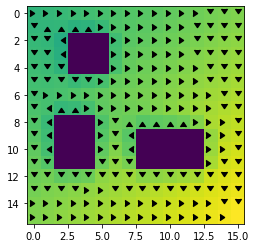

In [1]:
import numpy as np
import matplotlib.pyplot as plt



class ValueIteration(object):
    """
    ValueIteration(num_states, num_actions, rewards, state_transition_probs, discount)
    Finds an optimal value and a policy of a Markov decision process.
    Parameters
    ----------
    num_states : int
        Number of elements in the set of states.
    num_actions : int
        Number of elements in the set of actions.
    rewards : numpy.ndarray
        Reward values in given states and actions.
        $r(s, a)$.
    state_transition_probs : numpy.ndarray
        Probability in transion to a next state $s'$ given state $s$ and action $a$.
    """

    def __init__(self, num_states, num_actions, rewards, state_transition_probs, discount):

        self.rewards = rewards
        self.discount = discount
        self.state_transition_probs = state_transition_probs
        self.policy = None

        # Initialize the current value estimate with zeros
        self.values = np.zeros((num_states))
    

    def update(self):
        
        # Compute the action values $Q(s,a)$
        _action_values = self.rewards + self.discount * np.sum(
            self.state_transition_probs * self.values, axis=2, keepdims=False
        )

        # Evaluate the deterministic policy $\pi(s)$
        self.policy = np.argmax(_action_values, axis=1)

        # Compute the values $V(s)$
        values = np.max(_action_values, axis=1, keepdims=False)

        # Compute the value difference $|\V_{k}-V_{k+1}|\$ for check the convergence
        diff = np.linalg.norm(self.values[:] - values[:])

        # Update the current value estimate
        self.values = values

        return diff


    def fit(self, max_iteration=1e3, tolerance=1e-3, verbose=False, logging=False):
        
        if logging:
            history=[]

        # Value iteration loop
        for _iter in range(1, int(max_iteration+1)):

            # Update the value estimate
            diff = self.update()
            if logging:
                history.append(diff)
            if verbose:
                print('Iteration: {0}\tValue difference: {1}'.format(_iter, diff))

            # Check the convergence
            if diff < tolerance:
                if verbose:
                    print('Converged at iteration {0}.'.format(_iter))
                break

        if logging:
            return diff, history
        else:
            return diff



class PolicyIteration(object):
    """
    PolicyIteration(num_states, num_actions, rewards, state_transition_probs, discount)
    Finds an optimal value and a policy of a Markov decision process.
    Parameters
    ----------
    num_states : int
        Number of elements in the set of states.
    num_actions : int
        Number of elements in the set of actions.
    rewards : numpy.ndarray
        Reward values in given states and actions.
        $r(s, a)$.
    state_transition_probs : numpy.ndarray
        Probability in transion to a next state $s'$ given state $s$ and action $a$.
    """

    def __init__(self, num_states, num_actions, rewards, state_transition_probs, discount):
        
        self.rewards = rewards
        self.discount = discount
        self.state_transition_probs = state_transition_probs

        # Identity matrix $I_{|s|}$ and $I_{|a|}$ for computation
        self._I_s = np.eye(num_states)
        self._I_a = np.eye(num_actions)

        # Initialize the value estimate with $\infty$ for compute the value difference at first iteration
        self.values = np.empty([num_states])
        self.values.fill(np.inf)

        # Initilaize the random determinist policy
        self.policy = np.random.randint(low=0, high=num_actions, size=num_states)

        return None


    def update(self):
        
        # Convert the policy as a one-hot encoding for generate $P^{\pi}$ and $R^{\pi}$
        _one_hot_policy =  self._I_a[self.policy].astype(bool)

        # Compute the value $V(s)$ via solving the linear system $(I-\gamma P^{\pi}), R^{\pi}$
        values = np.linalg.solve(
            self._I_s - self.discount * self.state_transition_probs[_one_hot_policy],
            self.rewards[_one_hot_policy]
        )

        # Compute the action values $Q(s,a)$
        _action_values = self.rewards + self.discount * np.sum(
            self.state_transition_probs * values, axis=2, keepdims=False
        )

        # Evaluate the deterministic policy $\pi(s)$
        self.policy = np.argmax(_action_values, axis=1)

        # Compute the value difference $|\V_{k}-V_{k+1}|\$ for check the convergence
        diff = np.linalg.norm(self.values[:] - values[:])

        # Update the current value estimate
        self.values = values

        return diff


    def fit(self, max_iteration=1e3, tolerance=1e-3, verbose=False, logging=False):
        
        if logging:
            history=[]

        # Policy iteration loop
        for _iter in range(1, int(max_iteration+1)):

            # Update the value estimate and the polcy estimate
            diff = self.update()
            if logging:
                history.append(diff)
            if verbose:
                print('Iteration: {0}\tValue difference: {1}'.format(_iter, diff))

            # Check the convergence
            if diff < tolerance:
                if verbose:
                    print('Converged at iteration {0}.'.format(_iter))
                break

        if logging:
            return diff, history
        else:
            return diff



def gridworld(Model, discount=0.99):
    """
    Test code for debugging
    """

    # Setup the number of states and actions
    n_x = 16
    n_y = n_x
    n_states = n_x * n_y

    def xy_to_s(x, y, dx=0, dy=0):
        # Convert the cartesian coordinate (x, y) to the index of the states s.
        if dx > 0:
            s = min(x + dx, n_x - 1) * n_y
        else:
            s = max(x + dx, 0) * n_y
        if dy > 0:
            s += min(y + dy, n_y - 1)
        else:
            s += max(y + dy, 0)
        return s


    actions = [
        ( 0,  0),
        ( 1,  0),
        (-1,  0),
        ( 0,  1),
        ( 0, -1)
    ]
    n_actions = 5

    # Setup the gridworld environment$
    env = np.zeros((n_x, n_y), dtype=float)
    obstacles = [ # rectangle (x1, x2, y1, y2)
        (2,  5,  3,  6),
        (8, 12,  2,  5),
        (9, 12,  8, 13)
    ]
    for x1, x2, y1, y2 in obstacles:
        env[x1:x2, y1:y2] = 1

    # Setup the reward $r(s,a)$
    # rewards = - np.ones((n_states, n_actions), dtype=float) * 1e-2
    rewards = np.zeros((n_states, n_actions), dtype=float)
    rewards[:, 1:] -= 1e-2 # Negative reward for reduce energy consumption
    rewards[-1, 0] += 1 # Positive reward for target location
    

    # Setup the random state transition probability $P(s'|s,a)$
    p_success = 0.8 # Prob. of moving to the desired neighboring cell.
    p_fail = (1 - p_success) / (n_actions-1)
    def prob(a, b):
        if a==b:
            return p_success
        else:
            return p_fail
    state_transition_probs = np.zeros((n_states, n_actions, n_states), dtype=float)
    for x in range(n_x):
        for y in range(n_y):
            s = xy_to_s(x, y)
            if env[x, y] == 1:
                # The robot is broken
                state_transition_probs[s, :, s] += 1
            else:
                for a in range(n_actions):
                    for i, (dx, dy) in enumerate(actions):
                        state_transition_probs[s, a, xy_to_s(x, y, dx, dy)] += prob(a, i)

    # Solve MDP via selected method
    model = Model(n_states, n_actions, rewards, state_transition_probs, discount)
    model.fit(max_iteration=1000, tolerance=0.001, verbose=True, logging=True)

    # Plot figures
    plt.imshow(model.values.reshape(n_x, n_y))
    yy, xx = np.meshgrid(range(n_y), range(n_x))
    xx = xx.ravel()
    yy = yy.ravel()
    m = [' ', 7, 6, 5, 4]
    for action in range(5):
        plt.scatter(
            yy[model.policy==action],
            xx[model.policy==action],
            c='k', marker=m[action]
        )
    plt.show()

    return model



if __name__=='__main__':

    gridworld(ValueIteration, discount=0.99)